# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [20]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [21]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.44534826 -1.5        -0.          0.
  6.98282194  5.99607611 -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [22]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [23]:
from ddpg_agent import Agent, ReplayBuffer 
from model import Actor, Critic
from collections import deque
import matplotlib.pyplot as plt
from workspace_utils import active_session
import torch

In [24]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64       # minibatch size
random_seed =4

shared_actor_local = Actor(state_size, action_size, random_seed)
shared_actor_target = Actor(state_size, action_size, random_seed)
shared_critic_local = Critic(state_size, action_size, random_seed)
shared_critic_target = Critic(state_size, action_size, random_seed)
shared_replay_buffer = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

agent1=Agent(state_size,
             action_size,
             shared_actor_local,
             shared_actor_target,
             shared_critic_local,
             shared_critic_target, 
             shared_replay_buffer,
             BATCH_SIZE,
             random_seed)

agent2=Agent(state_size,
             action_size,
             shared_actor_local,
             shared_actor_target,
             shared_critic_local,
             shared_critic_target, 
             shared_replay_buffer,
             BATCH_SIZE,
             random_seed)

In [25]:
def ddpg(n_episodes=1000, print_every=100):        
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent1.reset()
        agent2.reset()
        curr_scores = np.zeros(num_agents)
        t=0
        while True:
            action1 = agent1.act(states[0].reshape(1,-1)).squeeze().tolist()
            action2 = agent2.act(states[1].reshape(1,-1)).squeeze().tolist()
            actions = np.asarray([action1, action2])
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done                        
            agent1.step(states[0], action1, rewards[0], next_states[0], dones[0],t)
            agent2.step(states[1], action2, rewards[1], next_states[1], dones[1],t)
            curr_scores += rewards
            states = next_states
            t = t+1
            if np.any(dones):
                break
        print("\nCurrent Score: ",curr_scores)
        max_score = np.max(curr_scores)
        scores_deque.append(max_score)
        scores.append(max_score)
        if np.mean(scores_deque) >= 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_deque)))
            return scores
        print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(agent1.actor_local.state_dict(), 'checkpoint_actor1.pth')
        torch.save(agent1.critic_local.state_dict(), 'checkpoint_critic1.pth')
        torch.save(agent2.actor_local.state_dict(), 'checkpoint_actor2.pth')
        torch.save(agent2.critic_local.state_dict(), 'checkpoint_critic2.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_deque)))    
    return scores


Current Score:  [-0.01  0.  ]
Episode 1	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 2	Average Score: 0.0000

/home/workspace/ddpg_agent.py:110: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(),1)
/home/workspace/ddpg_agent.py:120: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.actor_local.parameters(),1)



Current Score:  [-0.01  0.  ]
Episode 3	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 4	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 5	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 6	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 7	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 8	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 9	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 10	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 11	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 12	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 13	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 14	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 15	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 16	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 17	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 18	Average Score: 0.000

Episode 132	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 133	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 134	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 135	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 136	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 137	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 138	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 139	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 140	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 141	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 142	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 143	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 144	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 145	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 146	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 147	Average Score: 0.0000
Curren

Episode 260	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 261	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 262	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 263	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 264	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 265	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 266	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 267	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 268	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 269	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 270	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 271	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 272	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 273	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 274	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 275	Average Score: 0.0000
Curren

Episode 388	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 389	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 390	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 391	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 392	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 393	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 394	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 395	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 396	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 397	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 398	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 399	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 400	Average Score: 0.0000

Current Score:  [-0.01  0.  ]
Episode 401	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 402	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 403	Average Score: 0.0000
Curre

Episode 516	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 517	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 518	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 519	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 520	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 521	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 522	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 523	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 524	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 525	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 526	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 527	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 528	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 529	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 530	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 531	Average Score: 0.0000
Curren

Episode 644	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 645	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 646	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 647	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 648	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 649	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 650	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 651	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 652	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 653	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 654	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 655	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 656	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 657	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 658	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 659	Average Score: 0.0000
Curren

Episode 772	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 773	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 774	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 775	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 776	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 777	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 778	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 779	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 780	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 781	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 782	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 783	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 784	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 785	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 786	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 787	Average Score: 0.0000
Curren


Current Score:  [-0.01  0.  ]
Episode 901	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 902	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 903	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 904	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 905	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 906	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 907	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 908	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 909	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 910	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 911	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 912	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 913	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 914	Average Score: 0.0000
Current Score:  [ 0.   -0.01]
Episode 915	Average Score: 0.0000
Current Score:  [-0.01  0.  ]
Episode 9

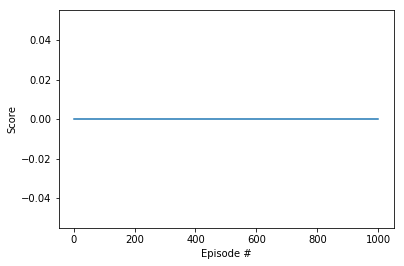

In [26]:
with active_session():
    scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()